In [7]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/aaa_ml/datasets/"

Mounted at /content/drive


In [1]:
import copy

import cv2 as cv2
import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm

In [5]:
latitude_range = (55.569184, 55.915168)
longitude_range = (37.324488, 37.859723)

moscow_map = folium.Map(location=[np.mean(latitude_range), np.mean(longitude_range)], zoom_start=10)



In [3]:
polygons = {
    'type': 'FeatureCollection',
    'features': [
        {'type': 'Feature',
         'id': '1',  # id полигона
         'properties': {'name': 'random_polygon', 'area_id': '1'},
         'geometry': {
             'type': 'Polygon',
             'coordinates': [
                 [[37.6164, 55.6518],
                  [37.7803, 55.6518],
                  [37.7803, 55.6974],
                  [37.6164, 55.6974],
                  [37.6164, 55.6518]]
             ]
         }
       }
    ]
}

In [4]:
data = pd.DataFrame(
    {'area_id': ['1'],  # id полигона
     'value': [1000],}
)
data

,area_id,value
0,1,1000


In [6]:
folium.Choropleth(
    geo_data=polygons,
    data=data,
    columns=['area_id', 'value'],
    name='value',
    key_on='feature.id',
    legend_name='value',
).add_to(moscow_map)

folium.LayerControl().add_to(moscow_map)  # кнопка управления слоями (в правом верхнем углу)

moscow_map

In [8]:
data = pd.read_csv(way + 'rent_prices_geodata.csv')
X, y = data[['latitude', 'longitude']], data['price']

model = DecisionTreeRegressor(min_samples_leaf=12, random_state=1)
model.fit(X, y)

DecisionTreeRegressor(min_samples_leaf=12, random_state=1)

In [9]:
num = 500
latitude_linspace = np.linspace(latitude_range[0], latitude_range[1], num=num)
longitude_linspace = np.linspace(longitude_range[0], longitude_range[1], num=num)
lat_grid, long_grid = np.meshgrid(latitude_linspace, longitude_linspace)
preds = np.zeros_like(lat_grid)

for i in tqdm(range(num)):
    for j in range(num):
        x, y = lat_grid[i, j], long_grid[i, j]
        p = model.predict([[x, y]])
        preds[i, j] = p

  0%|          | 0/500 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/usr/local/l

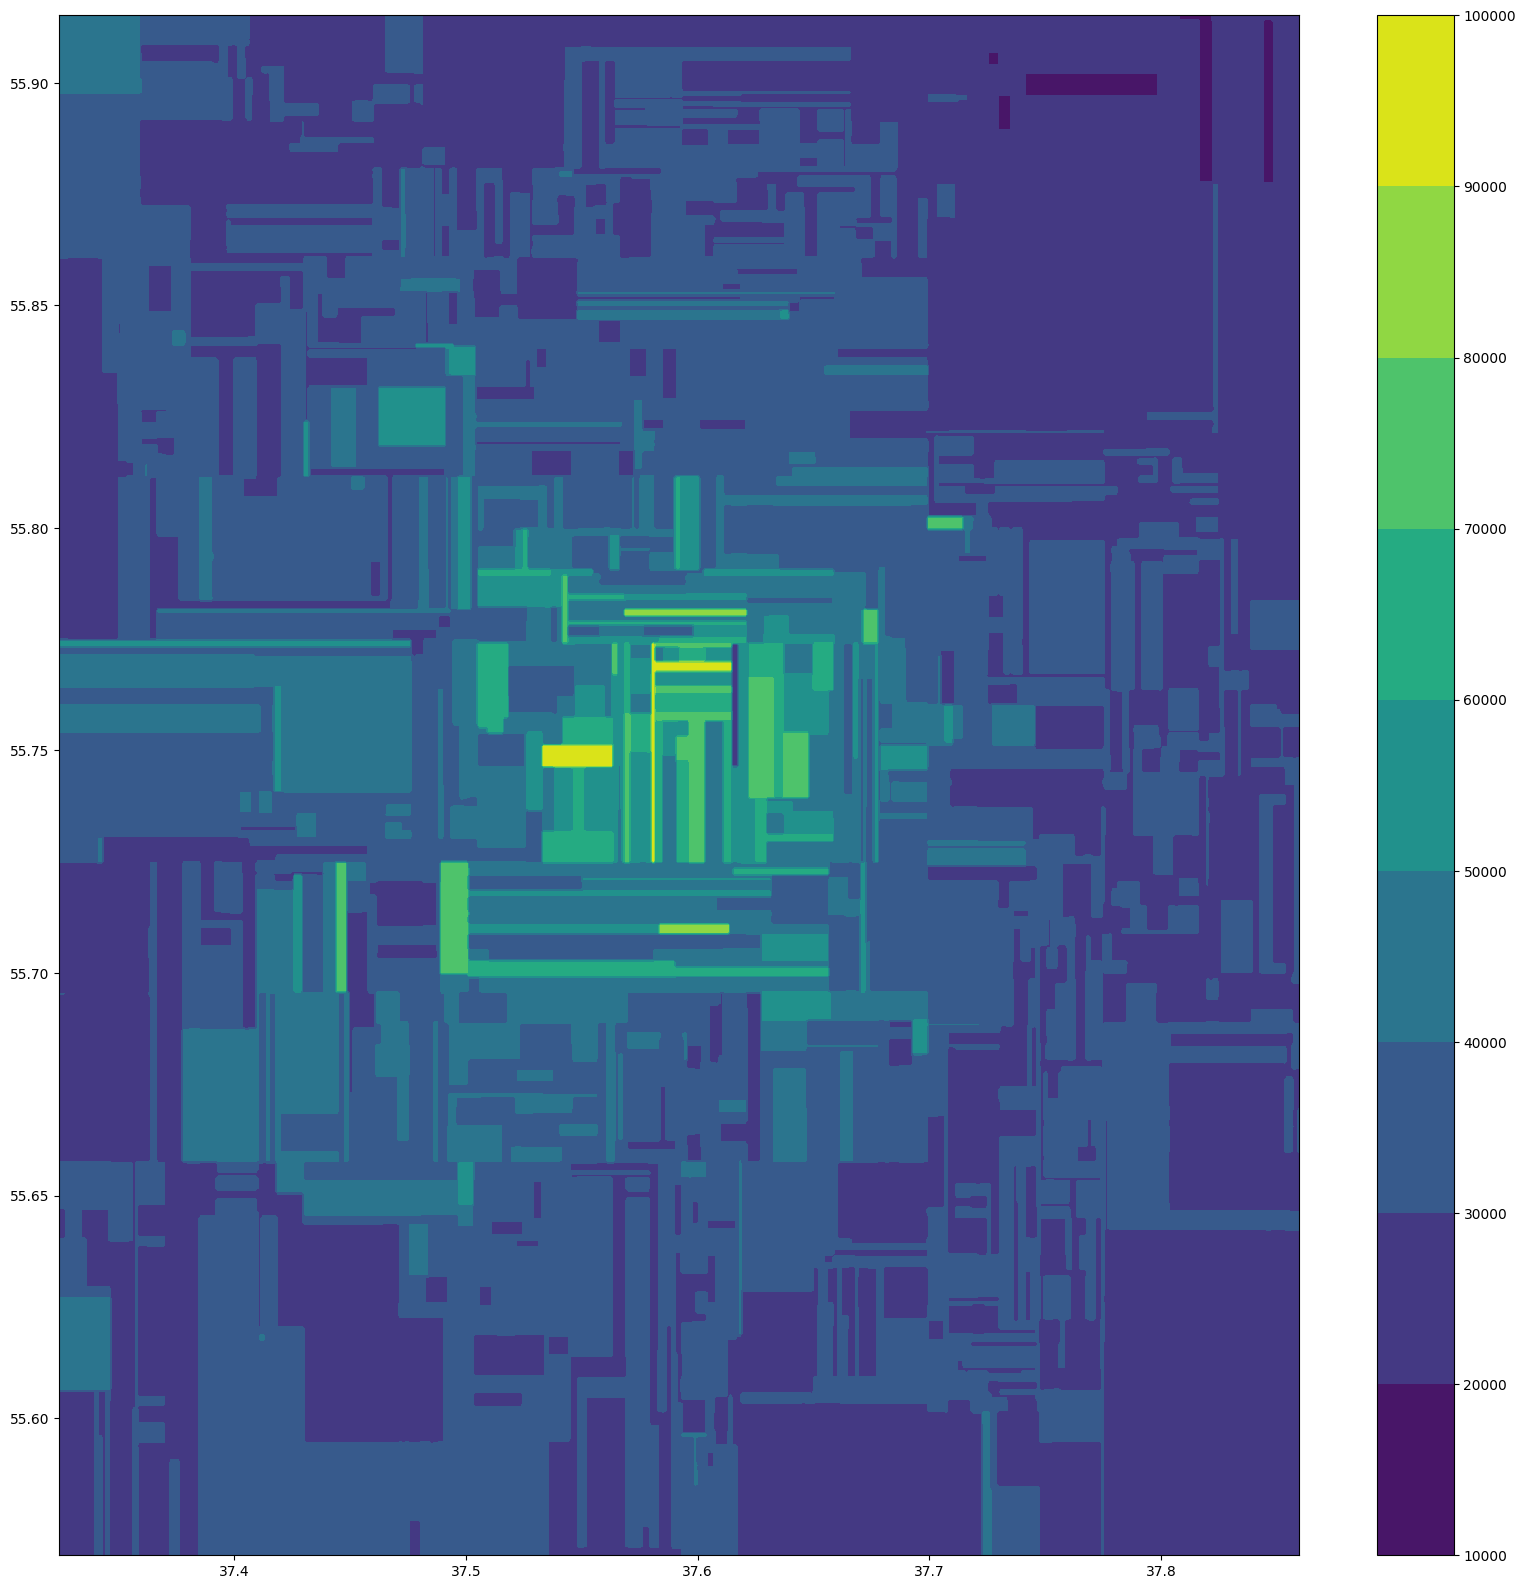

In [10]:
preds_rounded = preds.round(decimals=-3)
plt.figure(figsize=(20, 20))
plt.contourf(long_grid, lat_grid, preds_rounded)
plt.colorbar()

In [11]:
value = np.unique(preds_rounded)[1]
print(value)

20000.0


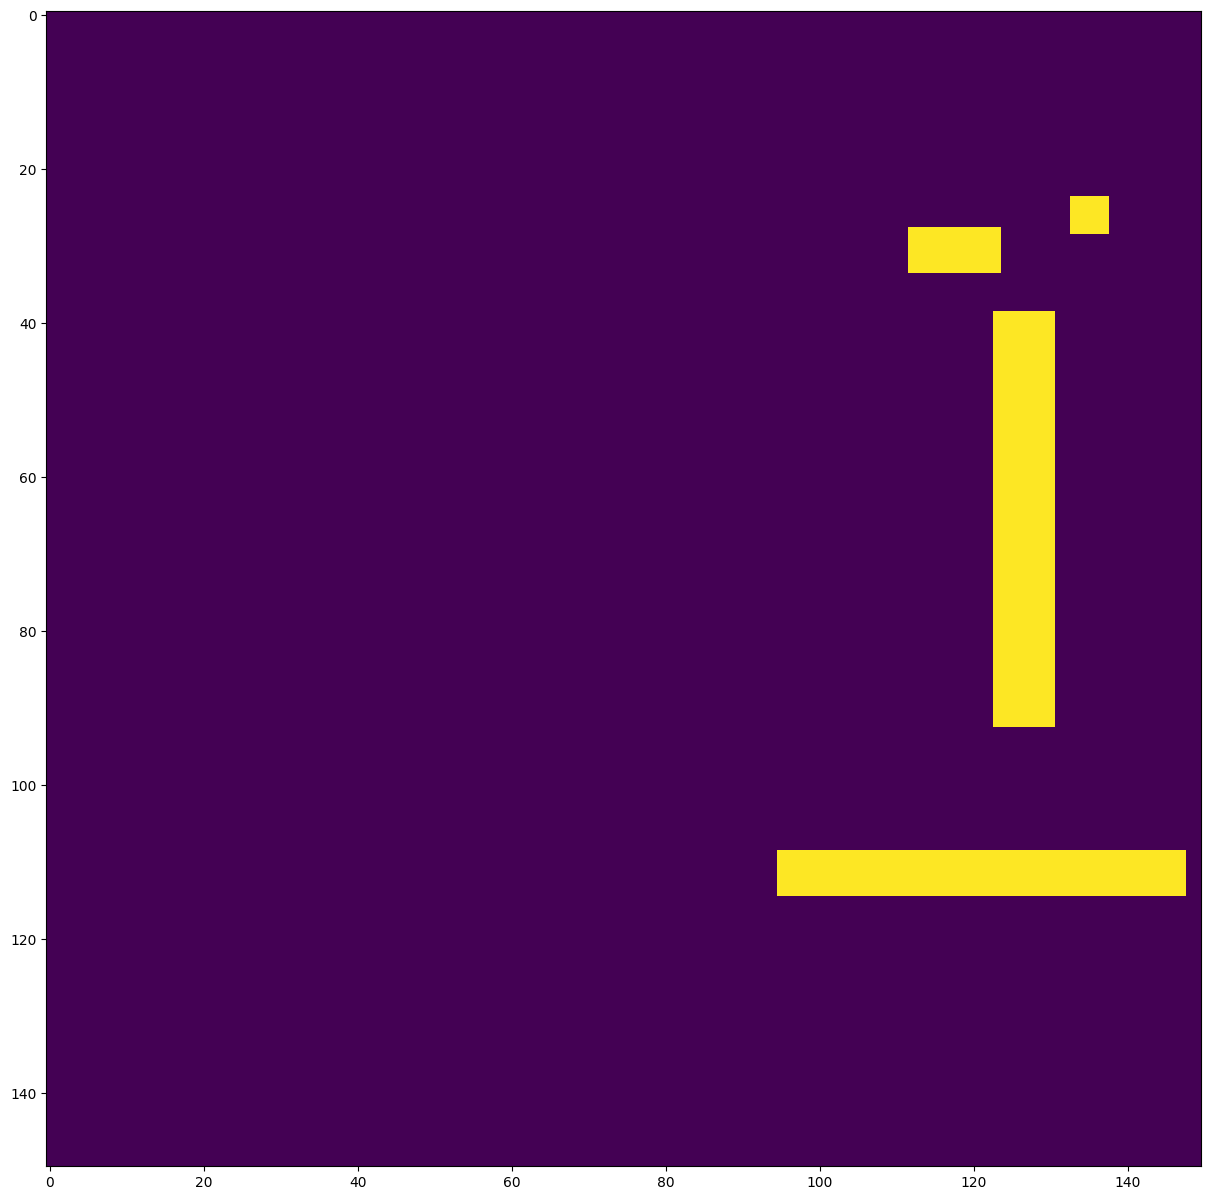

In [12]:
value_preds = (preds_rounded == value).astype('uint8')
plt.figure(figsize=(15, 15))
plt.imshow(value_preds[350:, 350:])

Для того, чтобы получить координаты полигонов, воспользуемся findContours из OpenCV


In [13]:
contours, _ = cv2.findContours(value_preds[350:, 350:], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours

(array([[[ 95, 109]],
 
        [[ 95, 114]],
 
        [[147, 114]],
 
        [[147, 109]]], dtype=int32),
 array([[[123,  39]],
 
        [[123,  92]],
 
        [[130,  92]],
 
        [[130,  39]]], dtype=int32),
 array([[[112,  28]],
 
        [[112,  33]],
 
        [[123,  33]],
 
        [[123,  28]]], dtype=int32),
 array([[[133,  24]],
 
        [[133,  28]],
 
        [[137,  28]],
 
        [[137,  24]]], dtype=int32))

In [14]:
def get_coords(points, lat, long):

    coods = []

    for point in points:
        point_lat = lat[0, point[0]]
        point_long = long[point[1], 0]
        coods.append([point_long, point_lat])

    return coods

get_coords(contours[0].squeeze(1), lat=lat_grid, long=long_grid)

[[37.441403060120244, 55.63505269739479],
 [37.44676613627255, 55.63505269739479],
 [37.44676613627255, 55.67110714228457],
 [37.441403060120244, 55.67110714228457]]

In [15]:
rent_price_geodata = {  # создадим пустой набор, в него будем складывать полигоны
    'type': 'FeatureCollection',
    'features': []
}
rent_price_data_dict = {'area_id': [], 'price': []}  # dataframe с связкой id и цены
polygon = {  # шаблон полигона из которого будут создаваться полигоны с константными предсказанием
    'type': 'Feature',
    'id': '1',
    'properties': {'name': 'constant price polygon', 'average price': 0},
    'geometry': {
        'type': 'Polygon',
        'coordinates': []
    }
}

# resize сетки широты долготы и предсказаний для заполнения зазоров между полигонами
lat_resized = cv2.resize(lat_grid, dsize=(2 * num, 2 * num), interpolation=cv2.INTER_NEAREST)
long_resized = cv2.resize(long_grid, dsize=(2 * num, 2 * num), interpolation=cv2.INTER_NEAREST)
preds_resized = cv2.resize(preds_rounded, dsize=(2 * num, 2 * num), interpolation=cv2.INTER_NEAREST)

id_number = 0  # инициализация id
unique_vals = np.unique(preds_rounded)
kernel = np.ones((2, 2), 'uint8')  # свёртка для функции delate

for val in unique_vals:  # итерируемся по всем значениям
    img = (preds_resized == val).astype(np.uint8) * 255  # создаем картинку с полигонами для значения val
    img = cv2.dilate(img, kernel)  # расширяем полигоны
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # находим координаты полигона на картинке

    for contour in contours:
        contour = contour.squeeze(1)
        coordinates = get_coords(contour, lat=lat_resized, long=long_resized)  # преобразуем в координаты географические

        contour_polygon = copy.deepcopy(polygon)  # копируем шаблон объекта полигона и все вложенные в него объекты
        countour_id = str(id_number)
        contour_polygon['id'] = countour_id
        id_number += 1

        contour_polygon['geometry']['coordinates'] = [coordinates]
        contour_polygon['properties']['average price'] = val
        rent_price_geodata['features'].append(contour_polygon)
        rent_price_data_dict['area_id'].append(countour_id)
        rent_price_data_dict['price'].append(val)

In [16]:
# функции стиля для выделения и popup сообщения
style_function = lambda x: {'fillColor': '#ffffff',
                            'color':'#000000',
                            'fillOpacity': 0.1,
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000',
                                'color':'#000000',
                                'fillOpacity': 0.50,
                                'weight': 0.1}

# объект карты
moscow_map = folium.Map(location=[np.mean(latitude_range), np.mean(longitude_range)], zoom_start=10)

# рисуем полигоны на карте
folium.Choropleth(
    geo_data=rent_price_geodata,
    data=pd.DataFrame(rent_price_data_dict),
    columns=['area_id', 'price'],
    name='rent price',
    key_on="feature.id",
    legend_name="Rent price",
    line_opacity=0.3,
    line_weight=0.3,
    fill_color='YlGnBu',
    fill_opacity=0.6
).add_to(moscow_map)


# выделение полигонов и popup
avg_prices = folium.features.GeoJson(
    data=rent_price_geodata,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['average price'],
        aliases=['Average rent price: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )

)

# добавляем выделение полигонов на карту
moscow_map.add_child(avg_prices)
moscow_map.keep_in_front(avg_prices)

# Кнопка контроля слоёв
folium.LayerControl().add_to(moscow_map)

moscow_map